In [2]:
%%capture
!pip install contextualized_topic_models

In [3]:
import pandas as pd    

!wget https://raw.githubusercontent.com/silviatti/Contextualized-Topic-Models-Tutorial/main/data/questions.en.jsonl
result = pd.read_json(path_or_buf='questions.en.jsonl', lines=True)
result.head()

--2022-03-14 14:13:01--  https://raw.githubusercontent.com/silviatti/Contextualized-Topic-Models-Tutorial/main/data/questions.en.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33999 (33K) [text/plain]
Saving to: ‘questions.en.jsonl.5’

questions.en.jsonl. 100%[===================>]  33.20K  --.-KB/s    in 0.002s  

2022-03-14 14:13:01 (19.0 MB/s) - ‘questions.en.jsonl.5’ saved [33999/33999]



,id,text,topic
0,2,Do you think it is fundamentally right that th...,Welfare
1,4,"Should a 24-week period of ""parental leave"" be...",Welfare
2,6,The disability insurance system no longer prov...,Welfare
3,7,Would you support a national hospital planning...,Healthcare
4,9,Do you think it's right that certain forms of ...,Healthcare


In [4]:
result['topic'].unique()

array(['Welfare', 'Healthcare', 'Education', 'Immigration', 'Society',
       'Security', 'Finances', 'Economy', 'Foreign Policy',
       'Infrastructure & Environment', 'Political System', 'Digitisation'],
      dtype=object)

In [5]:
result = result.drop_duplicates(subset=['text'])
result

,id,text,topic
0,2,Do you think it is fundamentally right that th...,Welfare
1,4,"Should a 24-week period of ""parental leave"" be...",Welfare
2,6,The disability insurance system no longer prov...,Welfare
3,7,Would you support a national hospital planning...,Healthcare
4,9,Do you think it's right that certain forms of ...,Healthcare
...,...,...,...
189,3464,Do you support an expansion of the legal possi...,Security
190,3468,Should Switzerland start membership negotiatio...,Foreign Policy
191,3469,Should Switzerland strive for a free trade agr...,Foreign Policy
192,3470,An initiative calls for liability rules for Sw...,Foreign Policy


In [6]:
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
import torch
import random
import numpy as np

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [7]:
def fix_seeds():
    torch.manual_seed(10)
    torch.cuda.manual_seed(10)
    np.random.seed(10)
    random.seed(10)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

## Preprocessing

In [8]:
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')
stopwords = list(set(stop_words.words('english')))

documents = result.text.tolist()
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cgarcia37/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
vocab[:10]

['farms',
 'direct',
 'crisis',
 'relaxing',
 'free',
 'rights',
 'pupils',
 'foreigners',
 'ban',
 'bvg']

In [10]:
preprocessed_documents[:5]

['think fundamentally right state financially support provision childcare working parents tax allowances subsidies',
 'week period parental leave introduced addition existing maternity insurance benefits',
 'disability insurance system longer provides disability benefits paid pain disorders cannot objectively proved result whiplash injury approve',
 'would support national hospital planning scheme even might lead closure hospitals',
 'think right certain forms alternative medicine reimbursed basic healthcare system']

In [11]:
unpreprocessed_corpus[:5]

['Do you think it is fundamentally right that the state should financially support the provision of childcare for working parents (through tax allowances or subsidies)?',
 'Should a 24-week period of "parental leave" be introduced in addition to the existing maternity insurance benefits?',
 'The disability insurance system no longer provides for disability benefits to be paid for pain disorders that cannot be objectively proved (e.g. as a result of whiplash injury). Do you approve?',
 'Would you support a national hospital planning scheme even if it might lead to the closure of hospitals?',
 "Do you think it's right that certain forms of alternative medicine are once again to be reimbursed under the basic healthcare system?"]

In [12]:
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Training

In [13]:
fix_seeds() # uncomment if you don't want to fix the random seeds

num_topics = 12
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=50)
#ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=50)
ctm.fit(training_dataset) # run the model

Epoch: [50/50]	 Seen Samples: [8650/8650]	Train Loss: 72.65300984465318	Time: 0:00:01.639126: : 50it [01:18,  1.56s/it]
Sampling: [20/20]: : 20it [00:32,  1.60s/it]


## Postprocessing

In [1]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

NameError: name 'ctm' is not defined

In [13]:
import pyLDAvis as vis
#pyLDAvis.enable_notebook()
#vis.enable_notebook()
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data, R=20)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:17,  1.72s/it]


In [14]:
ctm.get_topic_lists(5)

[['expanded', 'framework', 'tax', 'taxation', 'uber'],
 ['petrol', 'switzerland', 'co', 'fossil', 'fuels'],
 ['chf', 'minimum', 'wage', 'full', 'listed'],
 ['government', 'mountain', 'sites', 'focused', 'public'],
 ['refugees', 'united', 'accept', 'unhcr', 'asylum'],
 ['contributions', 'weak', 'cantons', 'road', 'women'],
 ['well', 'consumption', 'possession', 'legalize', 'soft'],
 ['schools', 'subjects', 'pe', 'swimming', 'events'],
 ['openly', 'telephone', 'security', 'political', 'socialization'],
 ['eu', 'trade', 'post', 'reliefs', 'agreement'],
 ['support', 'federal', 'government', 'financial', 'equal'],
 ['companies', 'human', 'relaxed', 'compliance', 'environmental']]

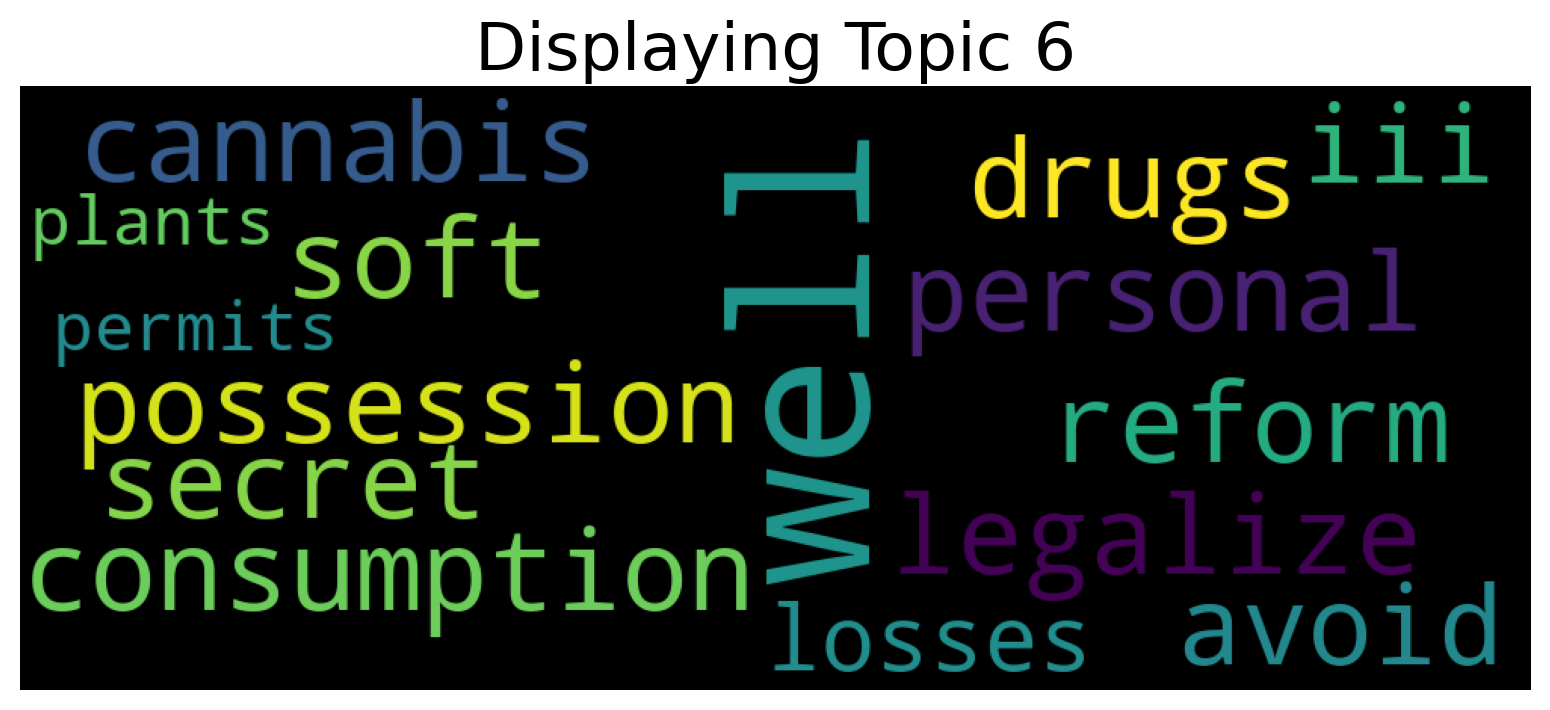

In [15]:
ctm.get_wordcloud(topic_id=6, n_words=15)

## Comparing with LDA

In [16]:
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaModel 
from gensim.models.coherencemodel import CoherenceModel

split_preprocessed_documents = [d.split() for d in preprocessed_documents]
dictionary = Dictionary(split_preprocessed_documents)
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

lda = LdaModel(corpus, num_topics=num_topics, iterations=500, random_state=42)

In [17]:
def get_topics_lda(topk=10):
    topic_terms = []
    for i in range(num_topics):
        topic_words_list = []
        for word_tuple in lda.get_topic_terms(i, topk):
            topic_words_list.append(dictionary[word_tuple[0]])
        topic_terms.append(topic_words_list)
    return topic_terms

get_topics_lda(5)

[['service', 'favour', 'federal', 'years', 'future'],
 ['think', 'refugees', 'increased', 'vaccination', 'countries'],
 ['support', 'switzerland', 'favour', 'federal', 'approve'],
 ['favour', 'construction', 'individual', 'operations', 'switzerland'],
 ['support', 'would', 'switzerland', 'level', 'cantons'],
 ['support', 'favour', 'building', 'services', 'federal'],
 ['switzerland', 'relaxed', 'consumption', 'chf', 'drugs'],
 ['switzerland', 'years', 'foreign', 'welcome', 'benefits'],
 ['switzerland', 'would', 'charge', 'support', 'fuels'],
 ['swiss', 'support', 'initiative', 'federal', 'switzerland'],
 ['switzerland', 'support', 'insurance', 'benefits', 'swiss'],
 ['swiss', 'support', 'federal', 'zurich', 'geneva']]

## Topic Coherence

In [19]:
cm = CoherenceModel(model=lda, dictionary=dictionary, 
                    texts=split_preprocessed_documents, coherence='c_npmi')
lda_coherence = cm.get_coherence()  # get coherence value
print("coherence score LDA:", lda_coherence)

coherence score LDA: -0.38652023652055956


In [20]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
corpus = [d.split() for d in preprocessed_documents]
coh = CoherenceNPMI(ctm.get_topic_lists(10), corpus)
print("coherence score CTM:", coh.score())

coherence score CTM: -0.17936184974516126


## Diversity of the topics

In [21]:
irbo_lda = InvertedRBO(get_topics_lda(10))
print("diversity score LDA:", irbo_lda.score())

irbo_ctm = InvertedRBO(ctm.get_topic_lists(10))
print("coherence score CTM:", irbo_ctm.score())

diversity score LDA: 0.817167000141342
coherence score CTM: 0.9960327574487013


## Topic Predictions

In [22]:
topics_predictions = ctm.training_doc_topic_distributions # get all the topic predictions
import numpy as np
train_doc_id = 1
topic_id = np.argmax(topics_predictions[train_doc_id]) # get the topic id of the  document
ctm.get_topic_lists(10)[topic_id]

['chf',
 'minimum',
 'wage',
 'full',
 'listed',
 'proposal',
 'men',
 'women',
 'scheme',
 'health']

In [23]:
unpreprocessed_corpus[train_doc_id]

'Should a 24-week period of "parental leave" be introduced in addition to the existing maternity insurance benefits?'

In [24]:
print("Original label:", result['topic'][train_doc_id])
print("Most likely topic:", ctm.get_topic_lists(10)[topic_id])

Original label: Welfare
Most likely topic: ['chf', 'minimum', 'wage', 'full', 'listed', 'proposal', 'men', 'women', 'scheme', 'health']


## Top K documents for a topic

In [25]:
topic_id = 1
print(ctm.get_topics()[topic_id])

['petrol', 'switzerland', 'co', 'fossil', 'fuels', 'given', 'voting', 'extended', 'currently', 'motor']


In [26]:
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, ctm.training_doc_topic_distributions, topic_id, k=7)

[('Switzerland currently levies a CO2 charge on fossil fuels (heating oil, natural gas). Should this charge be extended to motor fuels (e.g. petrol, diesel)?',
  0.8238243535161018),
 ('Currently, a CO2 charge is levied on fossil combustibles (e.g. heating oil, natural gas). Should this charge be extended to motor fuels (e.g. petrol, diesel)?',
  0.7153177313506603),
 ('Would you support the introduction of a CO2 tax on fuel if Switzerland were to fail to meet its own climate protection targets?',
  0.5445059522986412),
 ('An initiative calls for Switzerland to stop using fossil fuels by 2050. Do you support this proposal?',
  0.4685667347162962),
 ('The Federal Council is seeking to make Switzerland completely free of nuclear energy by 2034 at the latest (i.e. existing nuclear power plants will be decommissioned and no new ones will be built). Do you support this idea?',
  0.4620233863592148),
 ('A popular initiative is calling for the Federal Council to be directly elected by the Swi

In [28]:
# ctm.save(models_dir="./")
# ctm.load("Path", epoch=49) 


## Topic distribution on the overall corpus (training vs test)

In [29]:
labels = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 
          'topic_10', 'topic_11']        

In [30]:
topic_id = 4
print(ctm.get_topic_lists(10)[topic_id])
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, ctm.training_doc_topic_distributions, topic_id, k=5)

['refugees', 'united', 'accept', 'unhcr', 'asylum', 'integration', 'law', 'foreign', 'increased', 'countries']


[('The United Nations High Commissioner for Refugees (UNHCR) is seeking host countries for groups of refugees known as "quota refugees". Should Switzerland accept more of these groups?',
  0.780477324128151),
 ('Do you think Switzerland should accept an increased number of refugees directly from crisis regions for which the United Nations High Commissioner for Refugees (UNHCR) needs host countries (what is called quota refugees)?',
  0.7632217958569527),
 ('Are you in favor of further tightening the asylum law?',
  0.6175222862511873),
 ('Should access to "facilitated naturalization" via the Federation be made more difficult?',
  0.5294135477393865),
 ('Should the requirements for naturalization be increased?',
  0.5123111881315708)]

In [34]:
print(labels,"\n")

ctm.get_topic_lists(5)

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11'] 



[['expanded', 'framework', 'tax', 'taxation', 'uber'],
 ['petrol', 'switzerland', 'co', 'fossil', 'fuels'],
 ['chf', 'minimum', 'wage', 'full', 'listed'],
 ['government', 'mountain', 'sites', 'focused', 'public'],
 ['refugees', 'united', 'accept', 'unhcr', 'asylum'],
 ['contributions', 'weak', 'cantons', 'road', 'women'],
 ['well', 'consumption', 'possession', 'legalize', 'soft'],
 ['schools', 'subjects', 'pe', 'swimming', 'events'],
 ['openly', 'telephone', 'security', 'political', 'socialization'],
 ['eu', 'trade', 'post', 'reliefs', 'agreement'],
 ['support', 'federal', 'government', 'financial', 'equal'],
 ['companies', 'human', 'relaxed', 'compliance', 'environmental']]

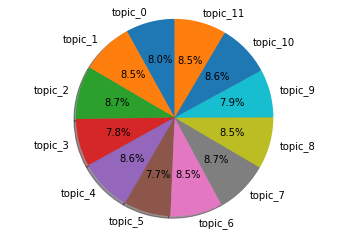

In [35]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(np.average(ctm.training_doc_topic_distributions,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

NameError: name 'test_topics_predictions' is not defined

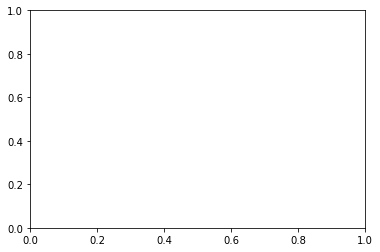

In [36]:
fig1, ax1 = plt.subplots()
ax1.pie(np.average(test_topics_predictions,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()